# Laboratorium 7 - Uczenie głębokie - dopasowanie obrazów
## Techniki Obrazowania Medycznego - AGH 
**Kontakt: wodzinski@agh.edu.pl / MSTeams**

W trakcie laboratorium zostanie poruszone zagadnienie dopasowania obrazów medycznych na przykładzie niesztywnego dopasowania obrazów histopatologicznych, wykorzystując algorytmy uczenia głębokiego.

Laboratorium można podzielić na następujące części:
<ul>
<li> Utworzenie pliku .csv zawierającego scieżki do par zdjęć, podział na podzbiory,
<li> Utworzenie datasetu i dataloaderów do wczytywania poszczególnych zbiorów,
<li> Implementacja sieci U-Net z minimalnymi modyfikacjami w celu przystosowania do problemu dopasowania,
<li> Nienadzorowany trening zaproponowanej sieci,
<li> Wizualna analiza uzyskanych rezultatów.
</ul>

Głównym celem laboratorium jest samodzielna implementacja odpowiedniej architektury i pętli uczącej dla treningu nienadzorowanego.

## Część 1 - Utworzenie pliku .csv zawierającego informacje o zbiorze danych i podział zbiorów

Podobnie jak na poprzednich zajęciach, rozpoczniemy od utworzenia pliku .csv zawierającego odpowiednie scieżki, a następnie podzielimy go na podzbiory.

Problem będziemy rozwiązywać na podstawie wstępnie przetworzonego i dopasowanego afinicznie zbioru danych ANHIR (https://anhir.grand-challenge.org/). Zbiór zawiera pary kolejno pozyskiwanych przekrojów wybarwianych różnymi czynnikami barwiącymi. Wykorzystywanie różnych czynników barwiących umożliwia lepszą diagnostykę, jednak wymaga wcześniejszego dopasowania poszczególnych przekrojów do wspólnego układu współrzędnych.

Na zajęciach będziemy rozwiązywać problem zdecydowanie uproszczony. Po pierwsze - dane są wstępnie dopasowane afinicznie, co w praktyce nie jest oczywiste i stanowi spore, dalej nierozwiązane zagadnienie badawcze. Po drugie, dane zostały zinterpolowane do bardzo małej rozdzielczości. Rzeczywiste dane histopatologiczne mogą mieć rozdzielczość przekraczającą 100 000 x 100 000 pikseli, co powoduje, że jakiekolwiek przetwarzanie ich w całości staje się niemożliwe (samo wczytanie i dekompresja jednego zdjęcia wymaga ponad 100 GB pamięci operacyjnej, bez uwzględnienia jakiegokolwiek dalszego przetwarzania).

Rozpocznijmy od importu bibliotek i utworzenia dedykowanych plików CSV. Zbiór jest wstępnie podzielony na zbiór treningowy i testowy. Oryginalny zbiór treningowy należy podzielić na zbiór treningowy i walidacyjny.

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install SimpleITK

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 48.4 MB 1.2 MB/s 


In [ ]:
#!unzip '/content/drive/My Drive/dat/ANHIR_Preprocessed.zip' -d '/content/drive/My Drive/dat'

In [3]:
import os

import math
import random

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import SimpleITK as sitk
from skimage import color

import torch as tc
import torch.nn as nn
import torch.nn.functional as F
from torchvision.transforms import ToTensor, Resize, Grayscale, RandomInvert

In [4]:
dataset_path = r'/content/drive/My Drive/dat/ANHIR_Preprocessed' #TODO - komórka gotowa, wystarczy jedynie podać scieżkę do zbioru danych
training_dataset_path = os.path.join(dataset_path, "Training")
testing_dataset_path = os.path.join(dataset_path, "Testing")

all_training_cases = os.listdir(training_dataset_path)
split_ratio = 0.9
random.shuffle(all_training_cases)
training_cases = all_training_cases[:int(len(all_training_cases)*split_ratio)]
validation_cases = all_training_cases[int(len(all_training_cases)*split_ratio):]
testing_cases = os.listdir(testing_dataset_path)

print(f"Number of training cases: {len(training_cases)}")
print(f"Number of validation cases: {len(validation_cases)}")
print(f"Number of testing cases: {len(testing_cases)}")

training_dataset_csv_path = os.path.join(dataset_path, "training_dataset.csv") # Sciezka do treningowego .csv
validation_dataset_csv_path = os.path.join(dataset_path, "validation_dataset.csv") # Sciezka do walidacyjnego .csv
testing_dataset_csv_path = os.path.join(dataset_path, "testing_dataset.csv") # Sciezka do testowego .csv

training_dataframe = pd.DataFrame(training_cases, columns=["Case"])
training_dataframe.to_csv(training_dataset_csv_path, index=False)

validation_dataframe = pd.DataFrame(validation_cases, columns=["Case"])
validation_dataframe.to_csv(validation_dataset_csv_path, index=False)

testing_dataframe = pd.DataFrame(testing_cases, columns=["Case"])
testing_dataframe.to_csv(testing_dataset_csv_path, index=False)


Number of training cases: 207
Number of validation cases: 23
Number of testing cases: 251


## Część 2 - Utworzenie dedykowanego dataloadera i datasetu

W kolejnym kroku należy zaimplementować dedykowany dataloader i dataset. W przypadku dopasowania obrazów interesuje nas wczytywanie par obrazów, tj. każde wywołanie funkcji __getitem__ powinno zwracać dwa obrazy: (i) obraz źródłowy (który będzie transformowany), oraz (ii) obraz docelowy (do którego obraz źródłowy będzie dopasowywany). Dla potrzeb wizualizacji oraz dalszego przetwarzania w datasecie użyj również opcjonalnego parametru __to_gray__, który będzie określać czy w trakcie wczytywania danych należy dokonać konwersji do skali szarości. Dodatkowo, w przypadku batch size > 1 będzie koniecznie wykorzystanie funkcji collate_to_list z uwagi na różne rozdzielczości par wejściowych.


In [5]:
def collate_to_list(batch):
    source = [item[0].view(*item[0].size()) for item in batch]
    target = [item[1].view(*item[1].size()) for item in batch]
    return source, target

class ANHIR_Dataset(tc.utils.data.Dataset):
  def __init__(self, dataset_path, csv_path, to_gray=True):
    self.dataset_path = dataset_path
    self.csv_path = csv_path
    self.to_gray = to_gray
    self.dataframe = pd.read_csv(csv_path)

  def __len__(self):
    return len(self.dataframe)
    
  def __getitem__(self, idx):
    current_path = self.dataframe.iloc[idx]['Case']

    source_path = os.path.join(self.dataset_path, str(current_path), "source.png")
    target_path = os.path.join(self.dataset_path, str(current_path), "target.png")

    source = sitk.GetArrayFromImage(sitk.ReadImage(source_path)).astype(np.float32)
    target = sitk.GetArrayFromImage(sitk.ReadImage(target_path)).astype(np.float32)

    source = (source - np.min(source)) / (np.max(source) - np.min(source)) 
    target =  (target - np.min(target)) / (np.max(target) - np.min(target))


    if self.to_gray:

      source = ToTensor()(source)
      target = ToTensor()(target)

      source = Grayscale(1)(source)
      target = Grayscale(1)(target)

      source = RandomInvert(p=1.0)(source)
      target = RandomInvert(p=1.0)(target)

      
      #TODO - dokonaj konwersji do skali szarosci, na tensor, odwrocenia intensywnosci, oraz normalizacji (w odpowiedniej kolejnosci)
    else:

      source = ToTensor()(source)
      target = ToTensor()(target)

     #TODO - dokonaj normalizacji oraz konwersji na tensor (w odpowiedniej kolejnosci)
    return source, target

Następnie utwórz dataloader testowy i dokonaj wizualizacji kilku przypadków (w kolorze):

In [6]:
testing_dataset = ANHIR_Dataset(testing_dataset_path, testing_dataset_csv_path, to_gray=False)
batch_size = 2
print(f"Dataset size: {len(testing_dataset)}")
testing_dataloader = tc.utils.data.DataLoader(testing_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_to_list)

Dataset size: 251


Sources size: torch.Size([3, 657, 512])
Targets size: torch.Size([3, 657, 512])


<Figure size 2400x1600 with 0 Axes>

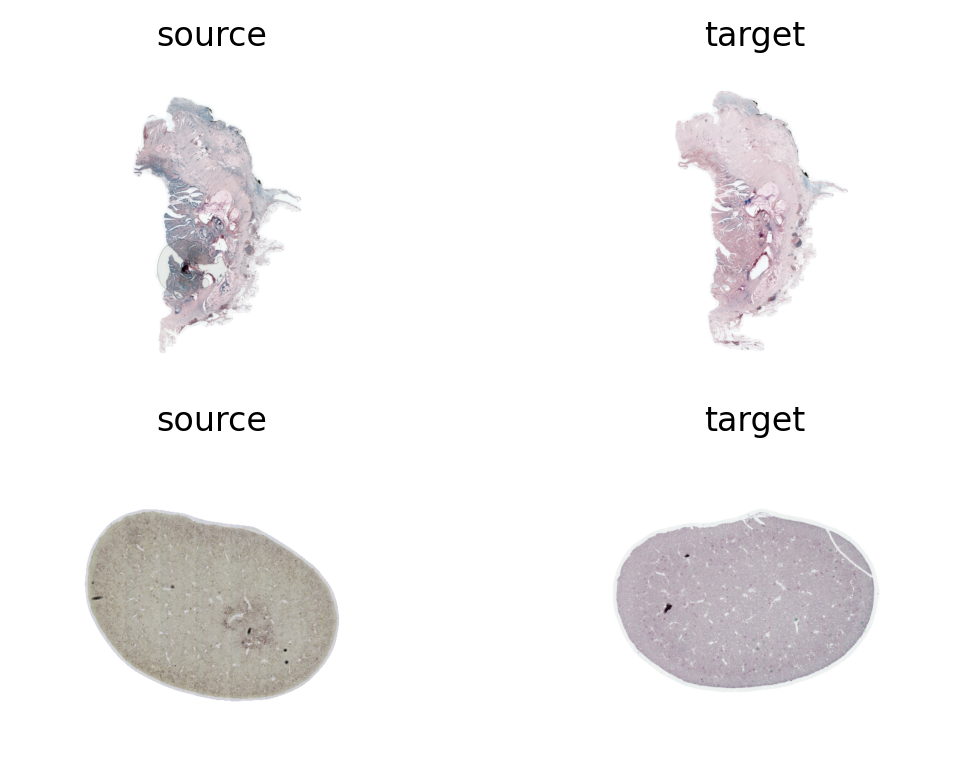

In [7]:
sources, targets = next(iter(testing_dataloader))

print("Sources size:", sources[0].shape)
print("Targets size:", targets[0].shape)

rows = batch_size
cols = 2
plt.figure(dpi=400)

x, y = next(iter(testing_dataloader))

plt.figure(dpi=200)
a = 1
for i in range(batch_size):
  
  plt.subplot(2, 2, i+a)
  img1 = x[i]
  plt.imshow(img1.permute(1, 2, 0))
  plt.title("source")
  plt.axis('off')

  a +=1

  plt.subplot(2, 2, i+a)
  img2 = y[i]
  plt.imshow(img2.permute(1, 2, 0).squeeze(axis=2), cmap="gray")
  plt.title("target")
  plt.axis('off')

plt.tight_layout()

## Część 3 - Zaimplementowanie sieci głębokiej

W kolejnym kroku dokonaj implementacji sieci U-Net (może być architektura z poprzednich zajeć) i postaraj się tak dopasować liczbę warstw, aby odpowiadała ona rozdzielczości zdjęć wejściowych. Dodatkowo, wyjście z sieci powinno zawierać dwa kanały, ponieważ chcemy zwracać pole przemieszczeń (https://en.wikipedia.org/wiki/Displacement_field_(mechanics)). Przed przystąpieniem do dalszej części warto odświeżyć wiedzę z zakresu fizyki/mechaniki o tym czym jest pole przemieszczeń oraz generalnie pole wektorowe. Pole przemieszczeń (wykorzystywane na Laboratorium 4 w kontekście transformacji niesztywnych) powinno być wyjściem z sieci neuronowej.

In [10]:
class Block(tc.nn.Module):
    def __init__(self, in_ch, out_ch, convtrans=False):
        super().__init__()

        self.layer = tc.nn.Sequential(
            tc.nn.Conv2d(in_ch, out_ch, 3, padding=1), 
            tc.nn.BatchNorm2d(out_ch),
            tc.nn.ReLU(inplace=True),
            tc.nn.Conv2d(out_ch, out_ch, 3, padding=1),
            tc.nn.BatchNorm2d(out_ch),
            tc.nn.ReLU(inplace=True)
        ) 

        self.conv = tc.nn.ConvTranspose2d(in_ch, out_ch, 2, 2)
        self.convtrans = convtrans

    def forward(self, x):
      if self.convtrans:
        x = self.conv(x)
        return x
      else:
        x = self.layer(x)
        return x



class UNet(tc.nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        self.enc1 = Block(3, 64)
        self.enc2 = Block(64, 128)
        self.enc3 = Block(128, 256)
        self.enc4 = Block(256, 512)
        self.enc5 = Block(512, 1024)

        self.pool = tc.nn.MaxPool2d(2, 2)

        self.dec1 = Block(1024, 512, convtrans=True)
        self.dec2 = Block(1024, 512)
        self.dec3 = Block(512, 256, convtrans=True)
        self.dec4 = Block(512, 256)
        self.dec5 = Block(256, 128, convtrans=True)
        self.dec6 = Block(256, 128)
        self.dec7 = Block(128, 64, convtrans=True)
        self.dec8 = Block(128, 64)

        self.last = tc.nn.Sequential(
             tc.nn.Conv2d(64, 1, 1),
             tc.nn.Sigmoid()
        )

    def forward(self, x):

        x1 = self.enc1(x) 
        x2 = self.pool(x1) 
        x3 = self.enc2(x2) 
        x4 = self.pool(x3) 
        x5 = self.enc3(x4) 
        x6 = self.pool(x5) 
        x7 = self.enc4(x6) 
        x8 = self.pool(x7) 
        x9 = self.enc5(x8) 

        y1 = self.dec1(x9) 
        y2 = self.dec2(tc.cat([y1, x7], 1))  
        y3 = self.dec3(y2) 
        y4 = self.dec4(tc.cat([y3, x5], 1))  
        y5 = self.dec5(y4) 
        y6 = self.dec6(tc.cat([y5, x3], 1))  
        y7 = self.dec7(y6) 
        y8 = self.dec8(tc.cat([y7, x1], 1)) 
        x = self.last(y8)  
        return x

In [13]:
class Registration_Network(nn.Module):
    def __init__(self):
        super(Registration_Network, self).__init__()
        # TODO - zaimplementuj architekture sieci (moze byc UNet) i przystosuj ja do problemu dopasowania - wymagane skuteczne dokonczenie Laboratorium 6

    def forward(self, source, target):
        pass #TODO - zaimplementuj logikę przejścia obu obrazów przez sieć - możesz zalozyc konkatenacje obu obrazow przed wejsciem do pierwszej warstwy (w wymiarze koloru)




def load_network(weights_path=None):
    #model = Registration_Network()
    model = UNet()
    if weights_path is not None:
        model.load_state_dict(tc.load(weights_path))
        model.eval()
    return model

def test_forward_pass():
    device = "cpu"
    model = load_network().to(device)
    y_size, x_size = 700, 512
    no_channels = 1
    batch_size = 1

    example_input_1 = tc.rand((batch_size, no_channels, y_size, x_size)).to(device)

    example_input_2 = tc.rand((batch_size, no_channels, y_size, x_size)).to(device)

    result = model(example_input_1, example_input_2)
    print("Result size: ", result.size())

test_forward_pass()

tensor([[[[0.8412, 0.3558, 0.4102,  ..., 0.7120, 0.5299, 0.7686],
          [0.4677, 0.6012, 0.5702,  ..., 0.6312, 0.9402, 0.8878],
          [0.5725, 0.5531, 0.1970,  ..., 0.8158, 0.5245, 0.7773],
          ...,
          [0.8565, 0.9629, 0.4211,  ..., 0.4451, 0.4903, 0.0627],
          [0.5336, 0.0605, 0.5011,  ..., 0.5973, 0.0032, 0.0196],
          [0.6310, 0.2967, 0.2093,  ..., 0.9481, 0.0284, 0.1936]]]])


TypeError: ignored

Następnie sprawdź czy przykładowe obrazy "przechodzą" przez sieć, czy nie jest zgłaszany żaden błąd oraz dokonaj wizualizacji wyników:

Dataset size: 251
Source min/max: (tensor(0.), tensor(1.))
Target min/max: (tensor(0.), tensor(1.))
Source min/max: (tensor(0.), tensor(1.))
Target min/max: (tensor(0.), tensor(1.))


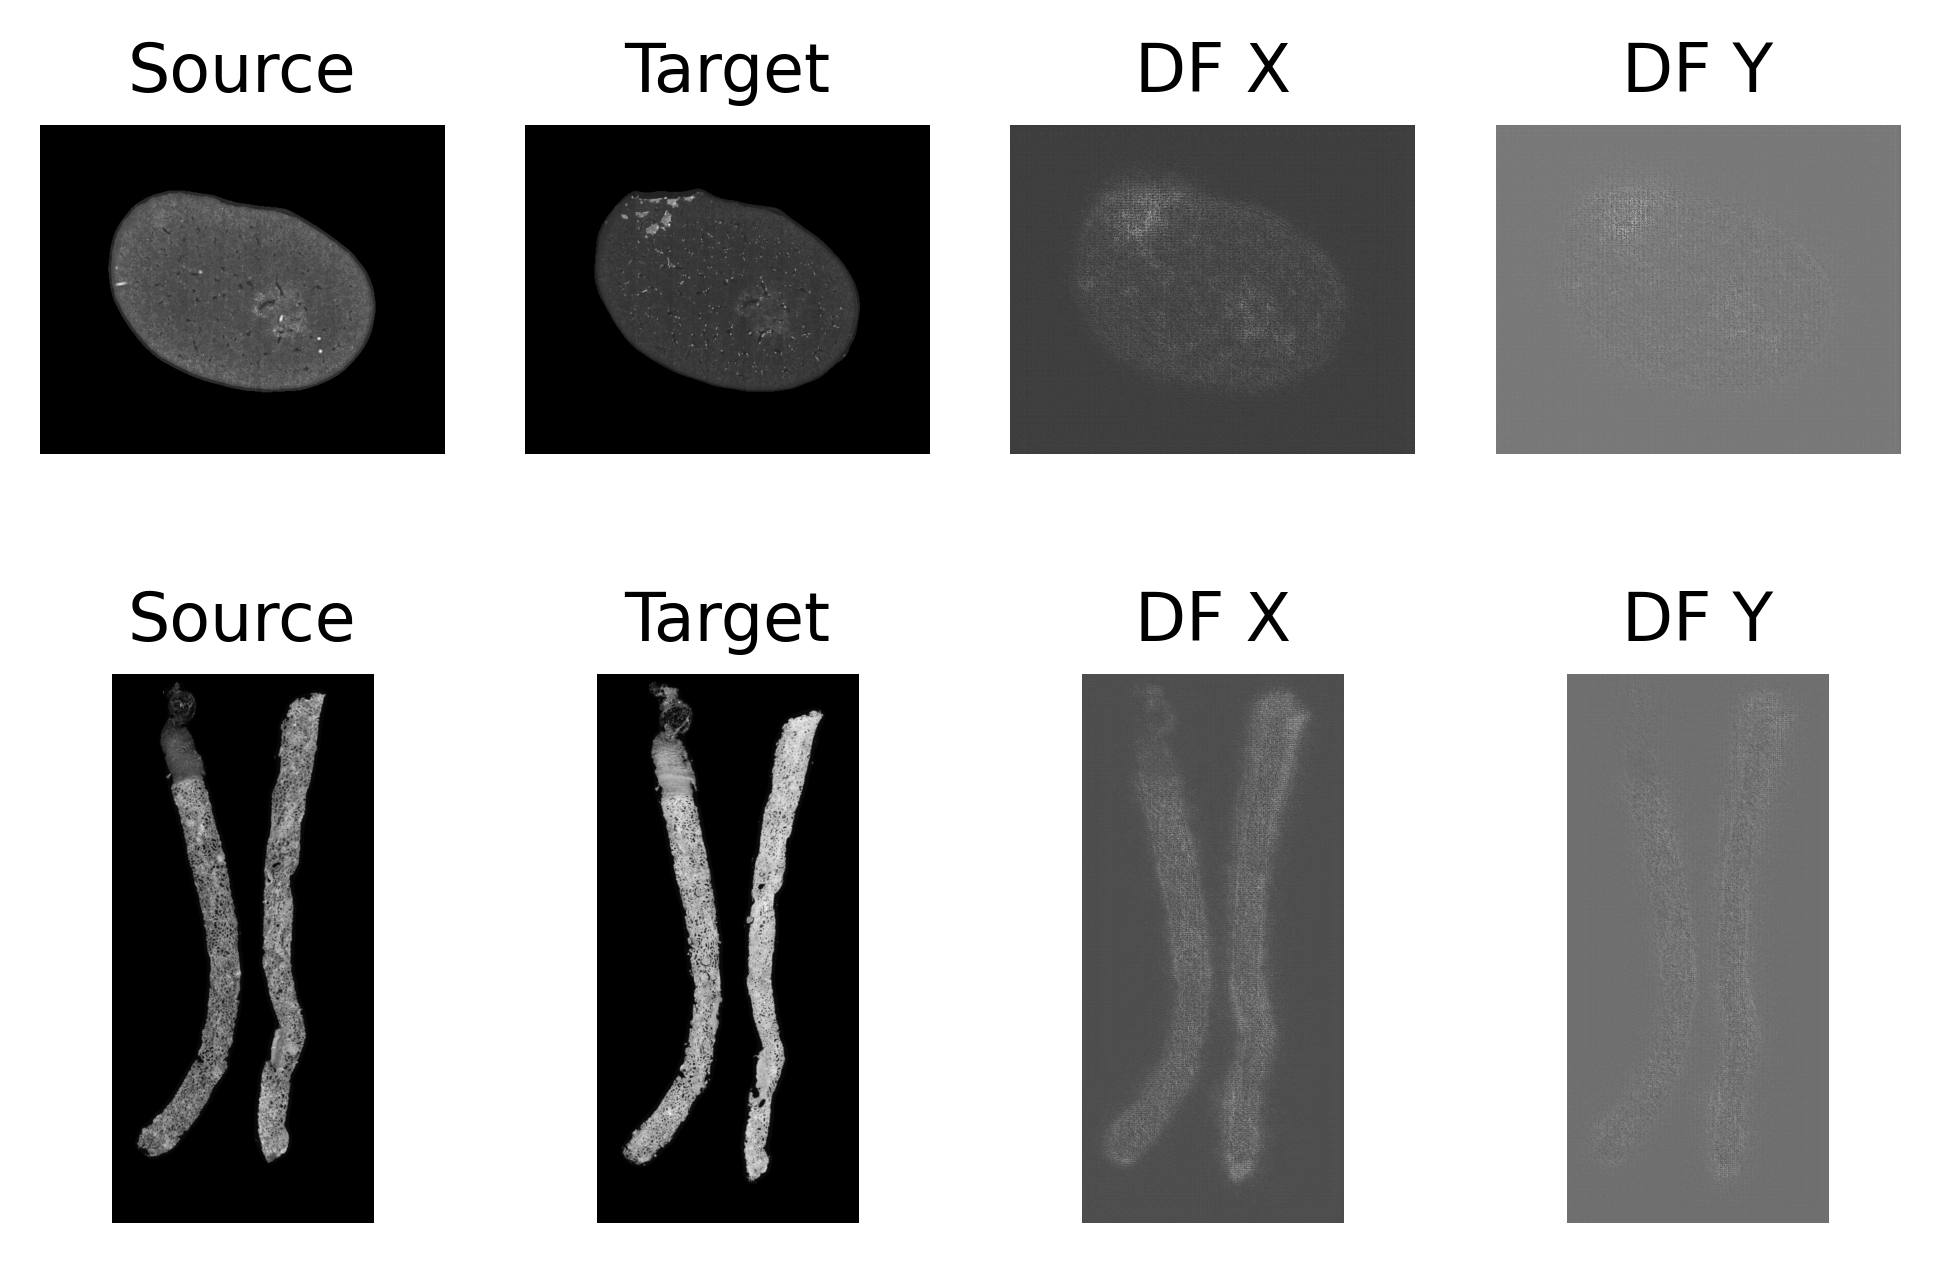

In [ ]:
model = Registration_Network()
testing_dataset = ANHIR_Dataset(testing_dataset_path, testing_dataset_csv_path, to_gray=True)
batch_size = 2
print(f"Dataset size: {len(testing_dataset)}")
testing_dataloader = tc.utils.data.DataLoader(testing_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_to_list)

for sources, targets in testing_dataloader:
    rows = batch_size
    cols = 4
    plt.figure(dpi=400)
    for i in range(batch_size):
        outputs = model(sources[i].unsqueeze(0), targets[i].unsqueeze(0))
        print(f"Source min/max: {sources[i].min(), sources[i].max()}")
        print(f"Target min/max: {targets[i].min(), targets[i].max()}")
        # TODO - dokonaj odpowiedniej wizualizacji
    plt.show()
    break

## Część 4 - Trening sieci głębokiej

W odróżnieniu do wcześniejszych zajęć, tym razem uczenie nie będzie polegało na uczeniu nadzorowanym. Celem będzie minimalizacja funkcji opisującej wzajemne zależności strukturalne. Na potrzeby laboratorium wykorzystamy sumę ważoną dwóch funkcji (i) znormalizowanej korelacji wzajemnej (NCC) w wersji lokalnej, (ii) regularyzacji dyfuzyjnej (zaimplementowanych poniżej). Należy tak zaimplementować pętlę uczącą, aby pole przemieszczeń wyznaczone przez sieć neuronową maksymalizowało wartość NCC między obrazem docelowym, a obrazem po transformacji i jednocześnie minimalizowało wartość regularyzacji dyfuzyjnej dla wyznaczanego pola przemieszczeń. Rozsądny parametr wielkości okna dla NCC to wartość między 13, a 21, a waga przypisywana regularyzacji dyfuzyjnej między 10000, a 100000 (zależna od dobranej wielkości okna dla NCC). Zauważ, że w przypadku treningu nienadzorowanego nie są potrzebne żadne manualne obrysy, bądź anotacje lekarskie.

Pętlę uczącą zaimplementuj od podstaw samodzielnie, korzystając z Laboratorium 6 oraz tematów poruszanych na Laboratorium 4.

Poniżej gotowe funkcje, które należy wykorzystać:

In [ ]:

def diffusion_regularization(displacement_field):
    """
    Funkcja implementująca regularyzacje dyfuzyjną.
    """
    dx = (displacement_field[:, 1:, :, :] - displacement_field[:, :-1, :, :])**2
    dy = (displacement_field[:, :, 1:, :] - displacement_field[:, :, :-1, :])**2
    diffusion_reg = (tc.mean(dx) + tc.mean(dy)) / 2
    return diffusion_reg

def ncc_local(sources, targets, **params):
    """
    Funkcja implementująca znormalizowaną korelację wzajemną w wersji lokalnej
    """
    ndim = len(sources.size()) - 2
    if ndim not in [2, 3]:
        raise ValueError("Unsupported number of dimensions.")
    try:
        win_size = params['win_size']
    except:
        win_size = 9
    window = (win_size, ) * ndim
    sum_filt = tc.ones([1, 1, *window], device=sources.device)
    pad_no = math.floor(window[0] / 2)
    stride = ndim * (1,)
    padding = ndim * (pad_no,)
    conv_fn = getattr(F, 'conv%dd' % ndim)
    sources_denom = sources**2
    targets_denom = targets**2
    numerator = sources*targets
    sources_sum = conv_fn(sources, sum_filt, stride=stride, padding=padding)
    targets_sum = conv_fn(targets, sum_filt, stride=stride, padding=padding)
    sources_denom_sum = conv_fn(sources_denom, sum_filt, stride=stride, padding=padding)
    targets_denom_sum = conv_fn(targets_denom, sum_filt, stride=stride, padding=padding)
    numerator_sum = conv_fn(numerator, sum_filt, stride=stride, padding=padding)
    size = np.prod(window)
    u_sources = sources_sum / size
    u_targets = targets_sum / size
    cross = numerator_sum - u_targets * sources_sum - u_sources * targets_sum + u_sources * u_targets * size
    sources_var = sources_denom_sum - 2 * u_sources * sources_sum + u_sources * u_sources * size
    targets_var = targets_denom_sum - 2 * u_targets * targets_sum + u_targets * u_targets * size
    ncc = cross * cross / (sources_var * targets_var + 1e-5)
    return -tc.mean(ncc)

def generate_grid(tensor_size, device="cpu"):
    """
    Funkcja pomocnicza do generowanie siatki regularnej.
    """
    identity_transform = tc.eye(len(tensor_size)-1, device=device)[:-1, :].unsqueeze(0)
    identity_transform = tc.repeat_interleave(identity_transform, tensor_size[0], dim=0)
    grid = F.affine_grid(identity_transform, tensor_size, align_corners=False)
    return grid

def warp_tensor(tensor, displacement_field, device="cpu", mode='bilinear'):
    """
    Funkcja do transformacji niesztywnej zdjęcia (tensora) wejściowego.
    """
    grid = generate_grid(tensor.size(), device=device)
    sampling_grid = grid + displacement_field
    transformed_tensor = F.grid_sample(tensor, sampling_grid, mode=mode, padding_mode='zeros', align_corners=False)
    return transformed_tensor

Poniżej pętla treningowa (do zaimplementowania):

Epoch: 1 Training Loss:  -0.15204504700962473
Epoch: 1 Training Reg:  2.426476378562823e-06
Epoch: 1 Training Cost:  -0.24910410198468516
Epoch: 1 Validation Loss:  -0.16117765819248947
Epoch: 1 Validation Reg:  2.3905893405516627e-06
Epoch: 1 Validation Cost:  -0.25680123237164126
Epoch: 2 Training Loss:  -0.15226343364099373
Epoch: 2 Training Reg:  2.2610467871288346e-06
Epoch: 2 Training Cost:  -0.24270530516542674
Epoch: 2 Validation Loss:  -0.15082896889551825
Epoch: 2 Validation Reg:  2.4231720080143018e-06
Epoch: 2 Validation Cost:  -0.24775584851918014
Epoch: 3 Training Loss:  -0.1571963667365664
Epoch: 3 Training Reg:  2.2148098910864083e-06
Epoch: 3 Training Cost:  -0.24578876152706608
Epoch: 3 Validation Loss:  -0.1632954261225203
Epoch: 3 Validation Reg:  2.3869135979428235e-06
Epoch: 3 Validation Cost:  -0.2587719695723575
Epoch: 4 Training Loss:  -0.16205556386550843
Epoch: 4 Training Reg:  2.226830902793663e-06
Epoch: 4 Training Cost:  -0.2511287993495015
Epoch: 4 Valida

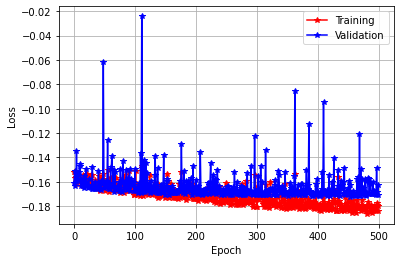

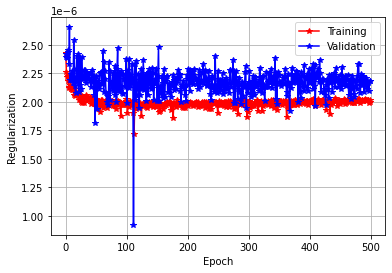

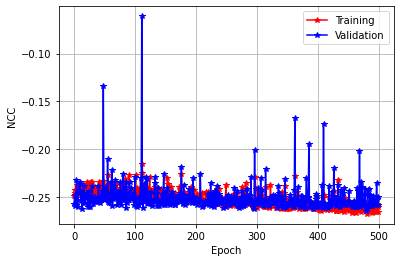

In [ ]:
# TODO - implementacja petli treningowej (zawierajacej operacje dla zbioru treningowego i walidacyjnego).
#  Ponizej przykladowe wyniki treningu dla 500 epoch, win_size = 15 i wagi wspolczynnika regularyzacji = 40000.
# Wyniki uzyskane przez zaimplementowana siec moga sie zdecydowanie roznic, jednak powinien byc widoczny spadek obu skladowych funkcji kosztu do podobnych wartosci.

## Część 5 - Jakościowa analiza wyników

Dla uproszczenia, w przypadku dopasowania obrazów nie będziemy dokonywać ilościowej oceny rezultatów (wymagałoby to implementacji dodatkowych funkcji, manualnej anotacji punktów ewaluacyjnych, oraz poruszenia tematów związanych z analizą pól wektorowych - treści poza zakresem przedmiotu). Zamiast tego dokonaj wizualnej oceny uzyskanych rezultatów, tj. pokaż dla losowo wybranych przypadków ze zbioru treningowego/testowego na wykresach obok siebie: (i) obraz źródłowy, (ii) obraz źródłowy po dopasowaniu, (iii) obraz docelowy.

Jak oceniasz (jakościowo) uzyskane rezultaty? Czy coś poszło nie tak? Czy potrafisz uzasadnić otrzymane wyniki? Czy ocena wizualna jest wiarygodna? Jak można poprawić wyniki?

Initial NCC: -0.03851686045527458
Warped NCC: -0.19345955550670624


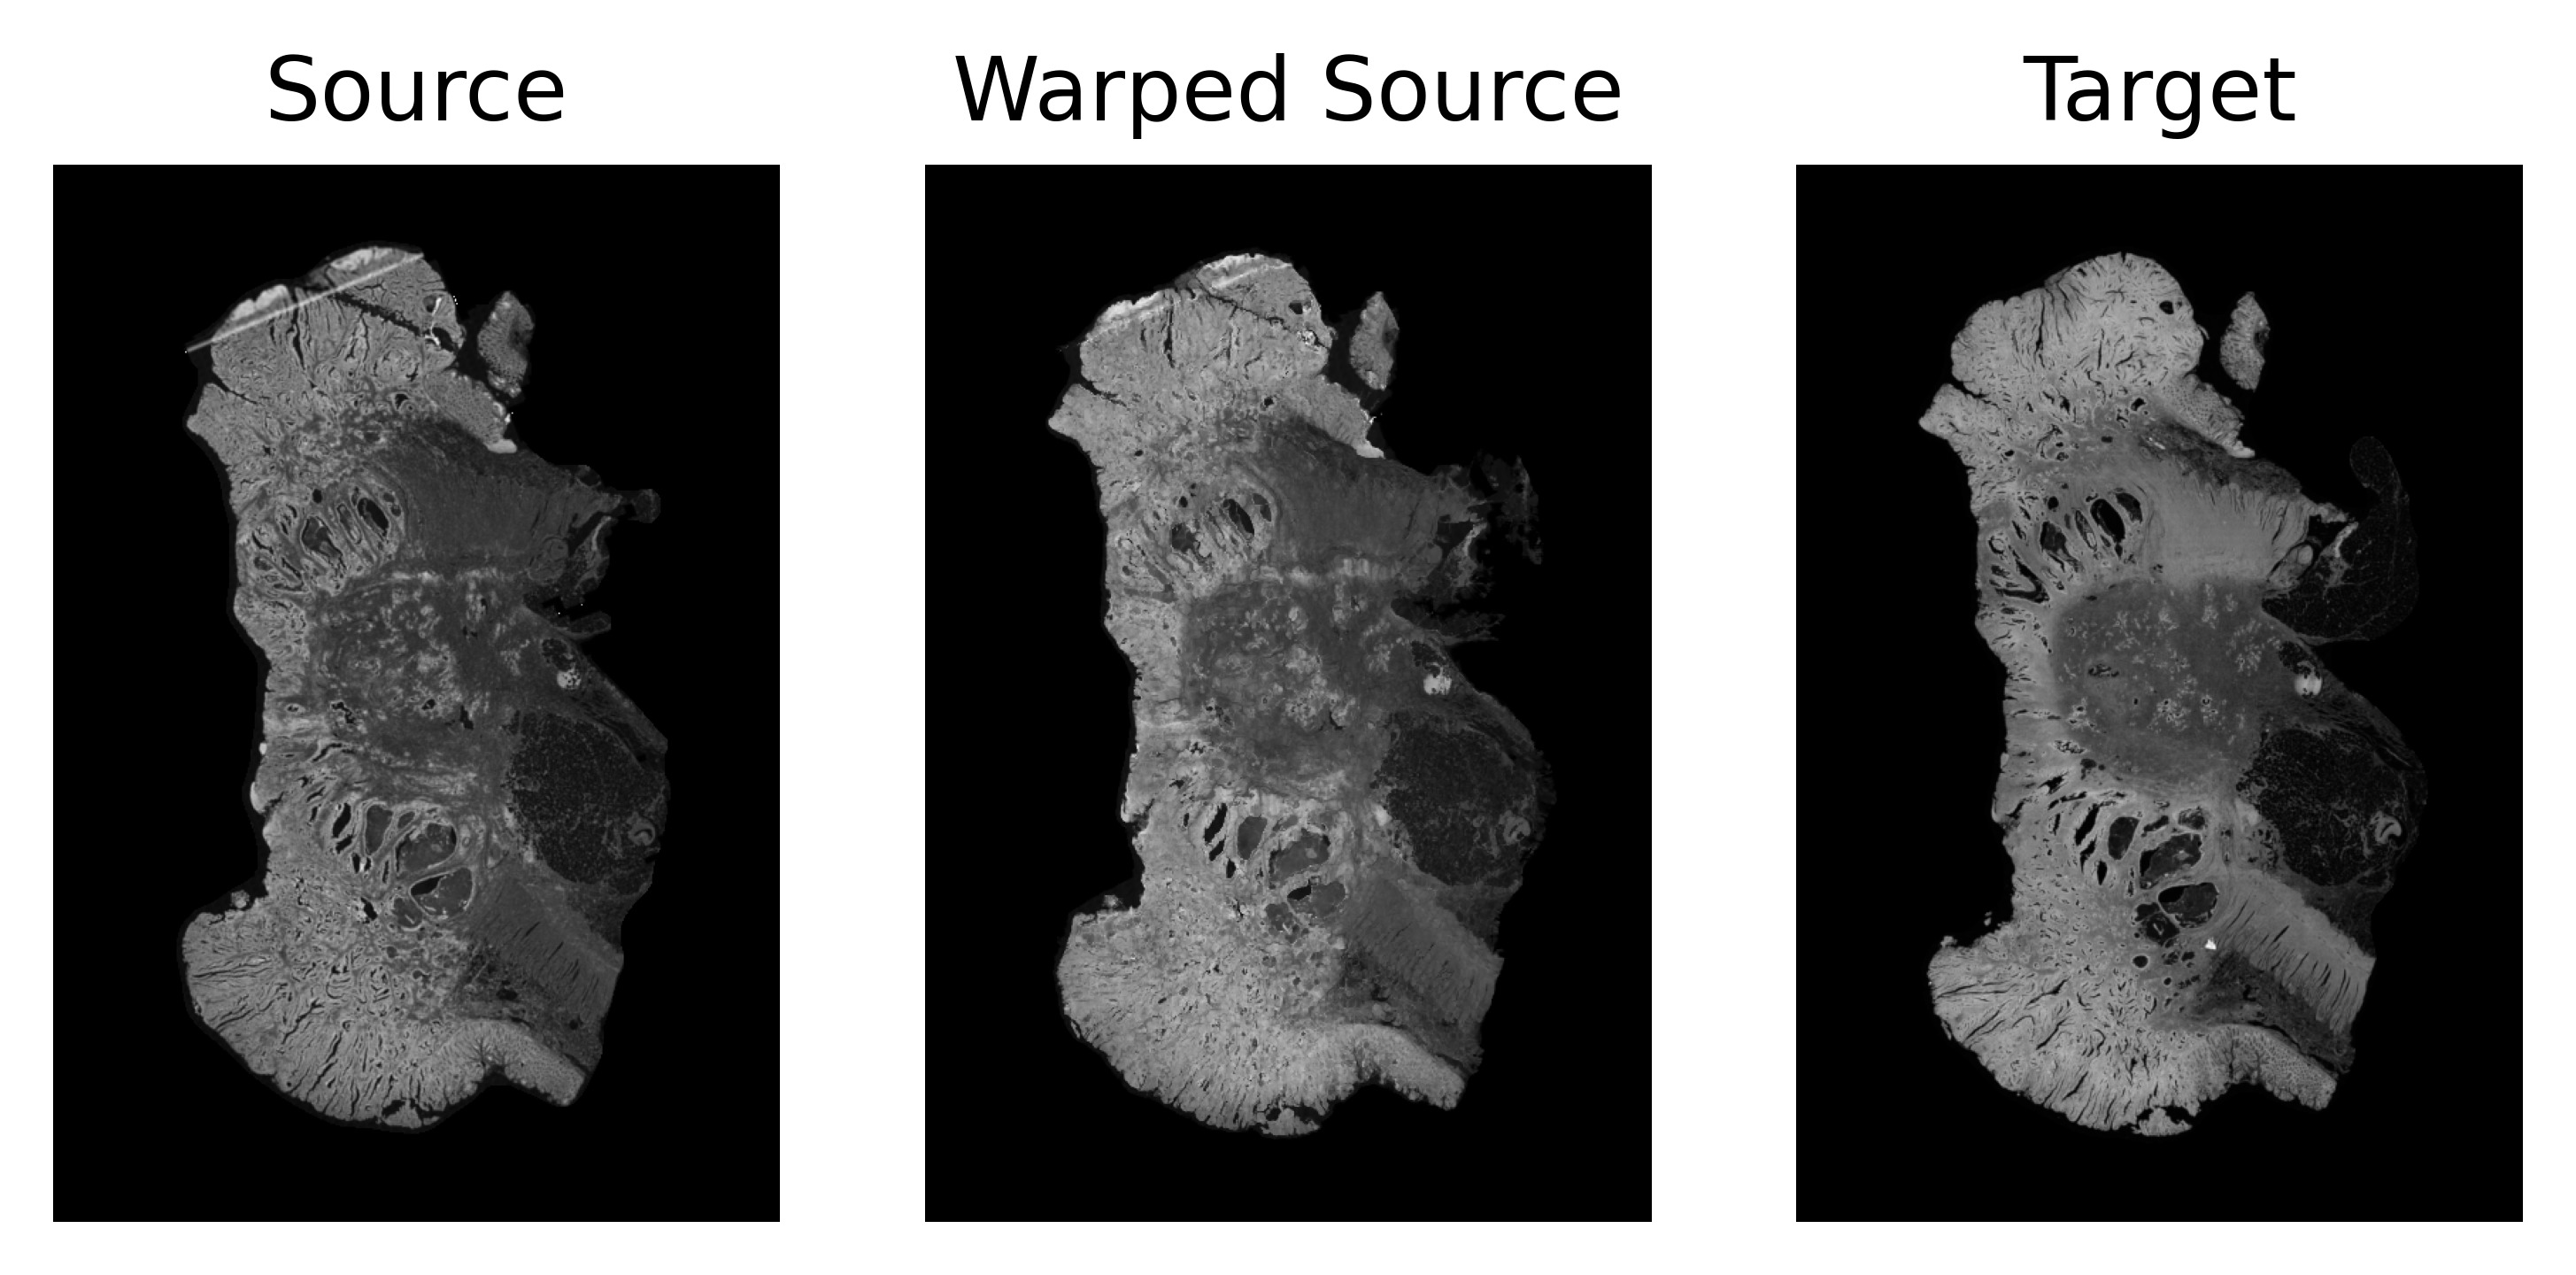

In [ ]:
batch_size = 1
testing_dataset = ANHIR_Dataset(testing_dataset_path, testing_dataset_csv_path, to_gray=True)
testing_dataloader = tc.utils.data.DataLoader(testing_dataset, batch_size=batch_size, shuffle=True, collate_fn=collate_to_list)

model.eval()
with tc.set_grad_enabled(False):
    for sources, targets in testing_dataloader:
        plt.figure(dpi=600)
        for i in range(batch_size):
            pass # TODO - dokonaj odpowiedniej wizualizacji
        plt.show()
        break
